In [1]:
import pandas as pd  
import matplotlib.pyplot as plt  
import statsmodels.api as sm  
from wordcloud import WordCloud  
from imageio import imread
import jieba  
from pylab import mpl 

In [2]:
# 使matplotlib模块能显示中文  
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题  

In [3]:
# 读取数据  
df = pd.read_csv('data\spider_data.csv', encoding = 'utf-8')  

In [4]:
# 剔除实习岗位  
df.drop(df[df['职位名称'].str.contains('实习')].index, inplace=True)  

In [5]:
df.describe()

,公司全名,公司简称,公司规模,融资阶段,区域,职位名称,工作经验,学历要求,工资,职位福利
count,450,450,449,449,447,450,450,450,450,450
unique,348,348,6,8,11,78,5,4,87,425
top,广州棒谷科技股份有限公司,广州棒谷科技股份有限公司,50-150人,不需要融资,天河区,产品经理,3-5年,本科,10k-20k,"周末双休,项目提成,股票期权,员工旅游"
freq,7,7,122,132,234,320,204,321,59,3


In [6]:
pattern = '\d+'  
df['工作年限'] = df['工作经验'].str.findall(pattern)

avg_work_year = []  
for i in df['工作年限']:  
    # 如果工作经验为'不限'或'应届毕业生',那么匹配值为空,工作年限为0  
    if len(i) == 0:  
        avg_work_year.append(0)  
   # 如果匹配值为一个数值,那么返回该数值  
    elif len(i) == 1:  
        avg_work_year.append(int(''.join(i)))  
   # 如果匹配值为一个区间,那么取平均值  
    else:  
        num_list = [int(j) for j in i]  
        avg_year = sum(num_list) / 2  
        avg_work_year.append(avg_year)
        
df['经验要求'] = avg_work_year
        
# 将字符串转化为列表,再取区间的前25%，比较贴近现实  
df['salary'] = df['工资'].str.findall(pattern)  

avg_salary = []  
for k in df['salary']:  
    int_list = [int(n) for n in k]  
    avg_wage = int_list[0]+(int_list[1]-int_list[0])/4  
    avg_salary.append(avg_wage) 

df['月工资'] = avg_salary

In [7]:
# 将清洗后的数据保存,以便检查  
df.to_csv('data\draft.csv', index = False)

In [8]:
# 读取数据  
draft = pd.read_csv('data\draft.csv', encoding = 'utf-8')  

In [9]:
# 描述统计  
print('工资描述：\n{}'.format(draft['月工资'].describe()))

工资描述：
count    450.000000
mean      12.599444
std        4.833817
min        1.250000
25%        9.750000
50%       11.250000
75%       15.000000
max       31.250000
Name: 月工资, dtype: float64


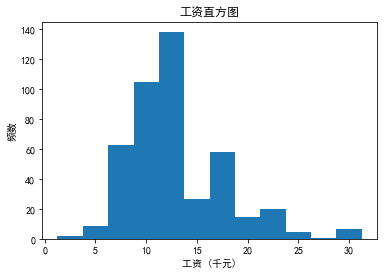

In [10]:
# 绘制频率直方图并保存  
plt.hist(df['月工资'],bins = 12)  
plt.xlabel('工资 (千元)')   
plt.ylabel('频数')   
plt.title("工资直方图")   
plt.savefig('output\histogram.jpg')  
plt.show()

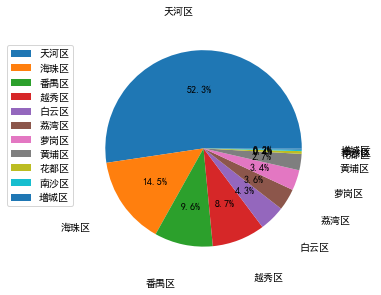

In [11]:
# 绘制饼图并保存  
count = df['区域'].value_counts()
plt.pie(count, labels = count.keys(),labeldistance=1.4,autopct='%2.1f%%')  
plt.axis('equal')  # 使饼图为正圆形  
plt.legend(loc='upper left', bbox_to_anchor=(-0.1, 1))  
plt.savefig('output\pie_chart.jpg')  
plt.show()  

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\gaiusyao\AppData\Local\Temp\jieba.cache
Loading model cost 0.800 seconds.
Prefix dict has been built succesfully.


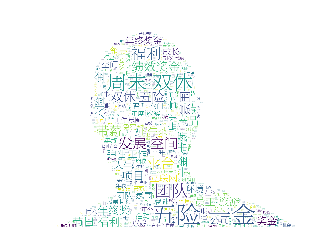

In [12]:
# 绘制词云,将职位福利中的字符串汇总  
text = ''  
for line in df['职位福利']:  
    text += line  
# 使用jieba模块将字符串分割为单词列表      
cut_text = ' '.join(jieba.cut(text))  
color_mask = imread('img\jobs.jpg')  #设置背景图  
cloud = WordCloud(  
    font_path = 'fonts\FZBYSK.ttf',   
    background_color = 'white',  
    mask = color_mask,  
    max_words = 1000,  
    max_font_size = 100          
)  

word_cloud = cloud.generate(cut_text)  

# 保存词云图片  
word_cloud.to_file('output\word_cloud.jpg')  
plt.imshow(word_cloud)  
plt.axis('off')  
plt.show()

In [13]:
# 实证统计,将学历不限的职位要求认定为最低学历:大专  
df['学历要求'] = df['学历要求'].replace('不限','大专')  

In [14]:
# 学历分为大专\本科\硕士,将它们设定为虚拟变量  
dummy_edu = pd.get_dummies(df['学历要求'], prefix = '学历') 

In [15]:
# 构建回归数组  
df_with_dummy = pd.concat([df['月工资'], df['经验要求'], dummy_edu], axis = 1)

In [16]:
# 建立多元回归模型  
y = df_with_dummy['月工资']  
X = df_with_dummy[['经验要求','学历_大专','学历_本科','学历_硕士']]  
X = sm.add_constant(X)   
model = sm.OLS(y, X.astype(float))  
results = model.fit()  
print('回归方程的参数：\n{}\n'.format(results.params))  
print('回归结果：\n{}'.format(results.summary()))

回归方程的参数：
const    6.560026
经验要求     1.205199
学历_大专    0.713301
学历_本科    2.661798
学历_硕士    3.184927
dtype: float64

回归结果：
                            OLS Regression Results                            
Dep. Variable:                    月工资   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     45.10
Date:                Thu, 28 Jun 2018   Prob (F-statistic):           1.79e-25
Time:                        23:15:02   Log-Likelihood:                -1287.4
No. Observations:                 450   AIC:                             2583.
Df Residuals:                     446   BIC:                             2599.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------